# Data Preprocessing

First, create a shortcut of the "Data Engineering (Shared Folder)" in My Drive (e.g., under your uchicago.edu Google Drive account).

When running the code below (drive.mount), use the Google account where the shortcut is located. (Log in with your uchicago.edu account here as well.)

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')
pth = '/content/drive/MyDrive/Stats Analysis Challenge/'
sys.path.append(pth)
data_folder_path = pth + 'Data'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, StrMethodFormatter
from scipy.special import comb
from itertools import chain, combinations
import pylab as py
import math
import calendar

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Function to process monthly reports
def process_monthly_report(file_path):
    raw_data = pd.read_excel(file_path, header=None)
    year_row = raw_data[raw_data.eq("Year").any(axis=1)].index[0]
    df = pd.read_excel(file_path, header=year_row)
    series_title_row = raw_data[raw_data[0].str.lower() == "series title:"].index[0]
    series_title = raw_data.iloc[series_title_row, 1]

    df = df.iloc[:, :13]
    df_long = pd.melt(df, id_vars=['Year'], var_name='Month', value_name=series_title)
    month_map = {month: index for index, month in enumerate(calendar.month_abbr) if month}
    df_long['Month'] = df_long['Month'].map(month_map)
    df_long['DATE'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'].astype(str))
    df_long = df_long[['DATE', series_title]]
    return df_long

In [ ]:
# Function to process quarterly reports
def process_quarterly_report(file_path):
    raw_data = pd.read_excel(file_path, header=None)
    year_row = raw_data[raw_data.eq("Year").any(axis=1)].index[0]
    df = pd.read_excel(file_path, header=year_row)
    return df

In [ ]:
# Lists to store data
quarterly_dataframes = []
monthly_dataframes = []
csv_dataframes = []

# Process all files in the folder
for file_name in os.listdir(data_folder_path):
    file_path = os.path.join(data_folder_path, file_name)

    if file_name in ['SeriesReport-20241206204149_d4617d.xlsx', 'SeriesReport-20241206204157_bf1ec0.xlsx']:
        # Process quarterly reports
        df_quarterly = process_quarterly_report(file_path)
        quarterly_dataframes.append((file_name, df_quarterly))
    elif file_name.endswith('.xlsx'):
        # Process monthly reports
        df_monthly = process_monthly_report(file_path)
        monthly_dataframes.append(df_monthly)
    elif file_name.endswith('.csv'):
        # Read CSV files and add to the list
        df_csv = pd.read_csv(file_path)
        df_csv['DATE'] = pd.to_datetime(df_csv['DATE'])
        csv_dataframes.append(df_csv)

In [ ]:
# Inner join all monthly reports by DATE
if monthly_dataframes:
    merged_monthly_df = monthly_dataframes[0]
    for df in monthly_dataframes[1:]:
        merged_monthly_df = merged_monthly_df.merge(df, on='DATE', how='inner')
    print(f"Merged Monthly Data Shape: {merged_monthly_df.shape}")

# Combine all CSV files by DATE using inner join
if csv_dataframes:
    merged_csv_df = csv_dataframes[0]
    for df in csv_dataframes[1:]:
        merged_csv_df = merged_csv_df.merge(df, on='DATE', how='outer')
    print(f"Merged CSV Data Shape: {merged_csv_df.shape}")

Merged Monthly Data Shape: (132, 7)
Merged CSV Data Shape: (1343, 11)


In [ ]:
df1 = quarterly_dataframes[1][1].iloc[:, :3].reset_index(drop=True)
df2 = quarterly_dataframes[0][1]

# Step 1: Process the first DataFrame
df1_long = pd.melt(
    df1,
    id_vars=['Year'],
    var_name='Quarter',
    value_name='% Change from previous quarter for Labor productivity (output per hour)'
)
df1_long['Quarter'] = df1_long['Quarter'].str.extract(r'(\d)').astype(int)
df1_long['DATE'] = pd.to_datetime(
    df1_long['Year'].astype(str) + '-' + (df1_long['Quarter'] * 3 - 2).astype(str) + '-01'
)

# Step 2: Process the second DataFrame
df2['Quarter'] = df2['Period'].str.extract(r'(\d)').astype(int)
df2['DATE'] = pd.to_datetime(df2['Year'].astype(str) + '-' + (df2['Quarter'] * 3 - 2).astype(str) + '-01')
df2 = df2.rename(columns={'Estimate Value': 'Total compensation for all civilian workers, 3-month percent change, current dollars'})

# Step 3: Inner join the two DataFrames on DATE
merged_quarterly_df = pd.merge(
    df1_long[['DATE', '% Change from previous quarter for Labor productivity (output per hour)']],
    df2[['DATE', 'Total compensation for all civilian workers, 3-month percent change, current dollars']],
    on='DATE',
    how='inner'
)

#### Now, we have three cleaned dataset:

`merged_csv_df`, `merged_monthly_df`, `merged_quarterly_df`

Merge `merged_csv_df` and `merged_monthly_df` by the unemployment rate and date.

Final potential variables (besides `DATE` and `UNRATE`):

- Seasonally Adjusted Variables:
  - <s>__LNS14000001__ (Unemployment Rate - Men)</s>
  - <s>__LNS14000002__ (Unemployment Rate - Women)</s>
  - __CORESTICKM159SFRBATL__ (Sticky Price Consumer Price Index (CPI))
  - __BOPTIMP__ (Imports of Goods and Services (Balance of Payments))
  - __BOPTEXP__ (Exports of Goods and Services (Balance of Payments))
  - __TOTAL_EMP__ (Total number of nonfarm payroll employees in thousands)
  - __HRLY_EARN__ (Average hourly earnings of private-sector employees)
  - __CPI_U__ (Consumer Price Index (CPI) for all urban consumers)

- NOT Seasonally Adjusted Variables:
  - __PPIACO__ (Producer Price Index for All Commodities)
  - __FEDFUNDS__ (Federal Funds Rate)

In [ ]:
# rearrange the time period from Nov 2020 to Dec 2024 for those three datasets by each year and so-on.
start_date = '2020-11-01' # two months lag to process time-series
end_date = '2024-12-31'

merged_monthly_df = merged_monthly_df.rename(columns={
    '(Seas) Unemployment Rate': 'UNRATE',
    'All employees, thousands, total nonfarm, seasonally adjusted': 'TOTAL_EMP',
    'Average hourly earnings of all employees, total private, seasonally adjusted': 'HRLY_EARN',
    'All items in U.S. city average, all urban consumers, seasonally adjusted': 'CPI_U',
    'PPI Commodity data for Final demand, seasonally adjusted': 'PPI_FD',
    'Monthly import price index for BEA End Use, All commodities, not seasonally adjusted': 'IMP_PRICE'
})

def process_data(df, filter):
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
    if filter:
        filtered_data = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    else:
        filtered_data = df
    return filtered_data

df_merged = pd.merge(process_data(merged_csv_df, False),
                     process_data(merged_monthly_df, False),
                     on=['UNRATE', 'DATE'], how='inner') # 2014-01-01 to 2024-11-01, 131 months
dfs_merged = pd.merge(process_data(merged_csv_df, True),
                      process_data(merged_monthly_df, True),
                      on=['UNRATE', 'DATE'], how='left') # 2021-01-01 to 2024-11-01, 49 months

In [ ]:
selected_columns = [
    "DATE",
    "UNRATE",
    # "LNS14000001",  # Unemployment Rate - Men
    # "LNS14000002",  # Unemployment Rate - Women
    "CORESTICKM159SFRBATL",  # Sticky Price Consumer Price Index (CPI)
    "PPIACO",  # Producer Price Index for All Commodities
    "BOPTIMP",  # Imports of Goods and Services (Balance of Payments)
    "BOPTEXP",  # Exports of Goods and Services (Balance of Payments)
    "FEDFUNDS",  # Federal Funds Rate
    "TOTAL_EMP",  # Total number of nonfarm payroll employees in thousands
    "HRLY_EARN",  # Average hourly earnings of private-sector employees
    "CPI_U"  # Consumer Price Index (CPI) for all urban consumers
]

dff = df_merged[selected_columns]
dffs = dfs_merged[selected_columns]

In [ ]:
dffs.head(5)

,DATE,UNRATE,CORESTICKM159SFRBATL,PPIACO,BOPTIMP,BOPTEXP,FEDFUNDS,TOTAL_EMP,HRLY_EARN,CPI_U
0,2020-11-01,6.7,1.697582,198.3,254051.0,189348.0,0.09,142761.0,29.63,260.895
1,2020-12-01,6.7,1.600671,200.5,257632.0,195610.0,0.09,142518.0,29.90,262.005
2,2021-01-01,6.4,1.400569,204.8,261054.0,198275.0,0.09,142916.0,29.93,262.518
3,2021-02-01,6.2,1.405123,210.6,261383.0,194984.0,0.08,143443.0,30.06,263.583
4,2021-03-01,6.1,1.592366,215.0,273759.0,207654.0,0.07,144274.0,30.06,264.910


# **EDA**

In [ ]:
check_missing = dffs.isnull().sum()
check_missing

,0
DATE,0
UNRATE,0
CORESTICKM159SFRBATL,1
PPIACO,1
BOPTIMP,1
BOPTEXP,1
FEDFUNDS,0
TOTAL_EMP,0
HRLY_EARN,0
CPI_U,1


In [ ]:
dffs.fillna(dffs.mean(), inplace=True)
dffs.isnull().sum()

,0
DATE,0
UNRATE,0
CORESTICKM159SFRBATL,0
PPIACO,0
BOPTIMP,0
BOPTEXP,0
FEDFUNDS,0
TOTAL_EMP,0
HRLY_EARN,0
CPI_U,0


In [ ]:
stats  = dffs.describe()
stats

,DATE,UNRATE,CORESTICKM159SFRBATL,PPIACO,BOPTIMP,BOPTEXP,FEDFUNDS,TOTAL_EMP,HRLY_EARN,CPI_U
count,49,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,2022-10-31 13:42:51.428571392,4.265306,4.302759,248.289687,315765.583333,244092.020833,2.834082,152800.857143,32.729388,293.178979
min,2020-11-01 00:00:00,3.400000,1.400569,198.300000,254051.000000,189348.000000,0.060000,142518.000000,29.630000,260.895000
25%,2021-11-01 00:00:00,3.600000,3.184384,241.338000,310795.000000,230642.000000,0.090000,149197.000000,31.240000,278.799000
50%,2022-11-01 00:00:00,3.800000,4.412395,253.860000,323266.000000,254374.000000,3.780000,154155.000000,32.830000,297.863000
75%,2023-11-01 00:00:00,4.300000,5.405751,257.897000,333920.000000,260783.000000,5.330000,157014.000000,34.230000,307.531000
max,2024-11-01 00:00:00,6.700000,6.538167,280.251000,353810.000000,272651.000000,5.330000,159288.000000,35.610000,315.454000
std,NaN,0.973086,1.532878,18.908002,26022.277911,23403.375163,2.357764,5187.564614,1.774527,17.270644


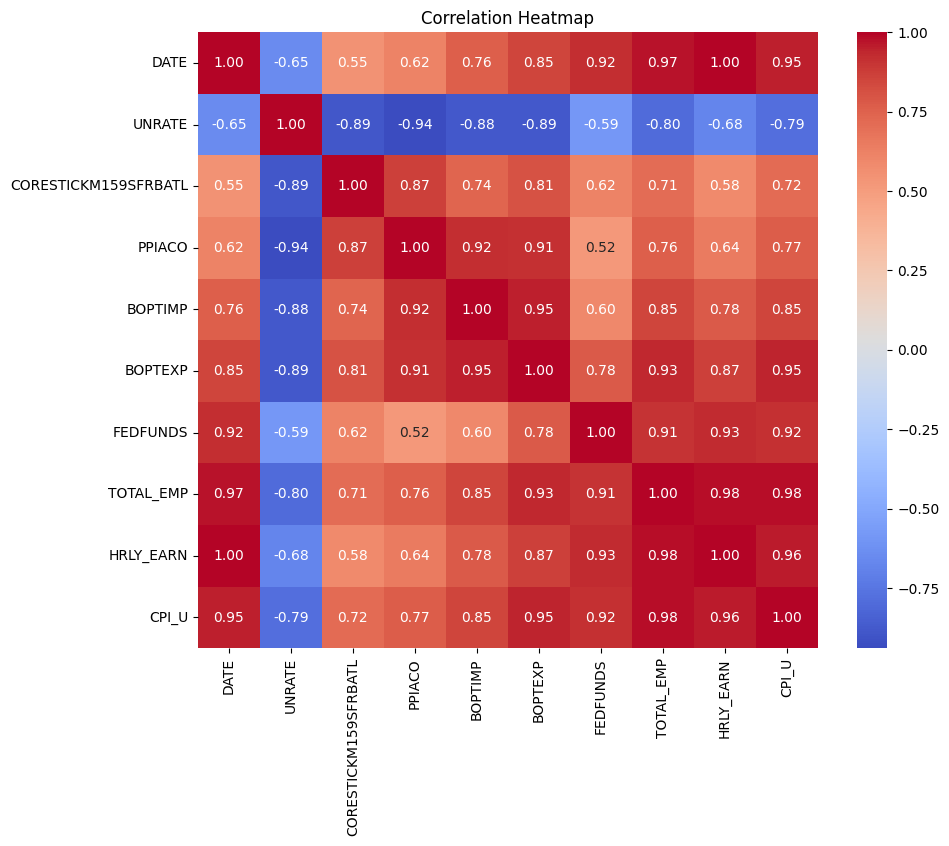

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = dffs.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

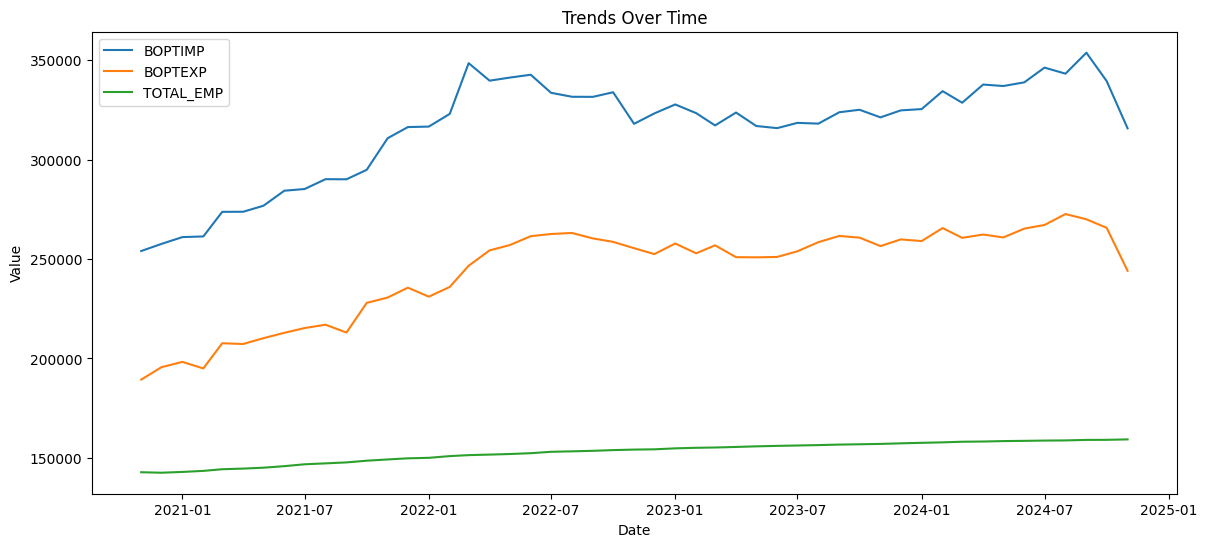

In [ ]:
# Visualize trends for some key columns over time
plt.figure(figsize=(14, 6))
for column in ['BOPTIMP','BOPTEXP', 'TOTAL_EMP']:
    plt.plot(dffs['DATE'], dffs[column], label=column)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends Over Time')
plt.legend()
plt.show()

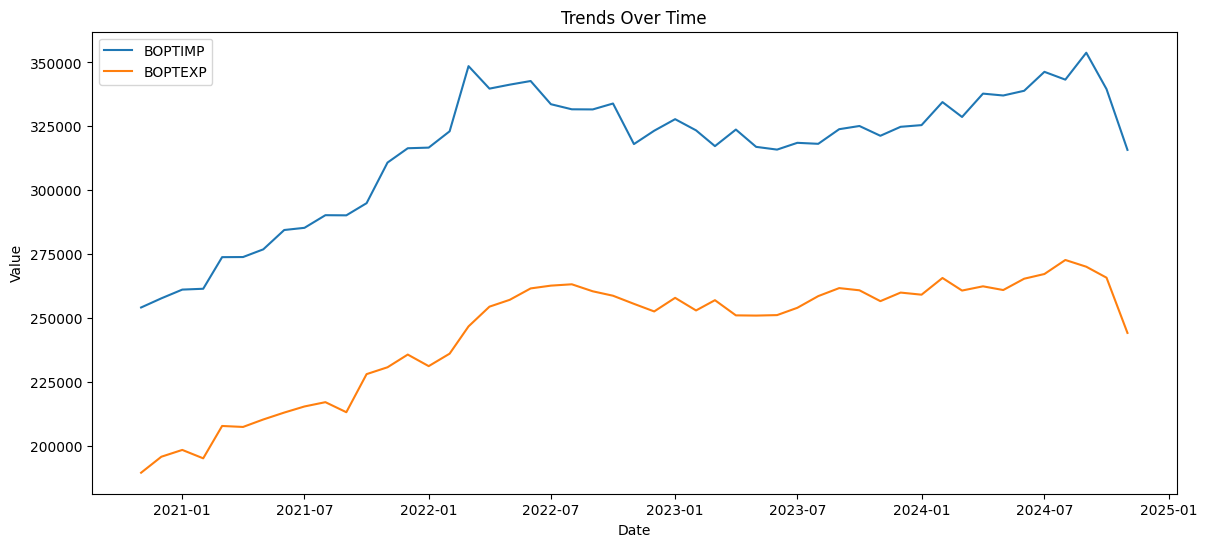

In [ ]:
plt.figure(figsize=(14, 6))
for column in ['BOPTIMP','BOPTEXP']:
    plt.plot(dffs['DATE'], dffs[column], label=column)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends Over Time')
plt.legend()
plt.show()

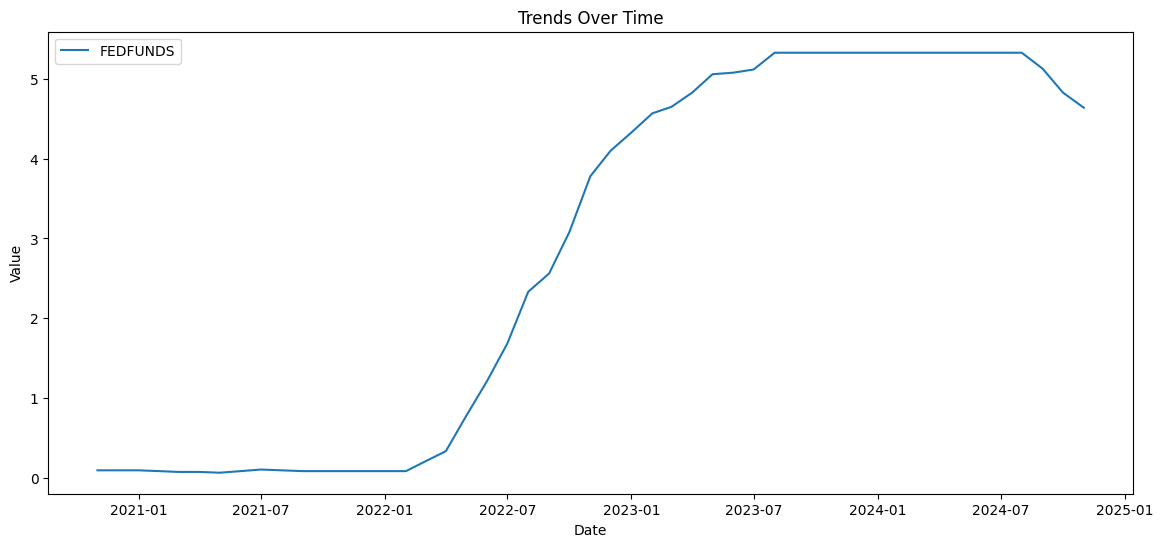

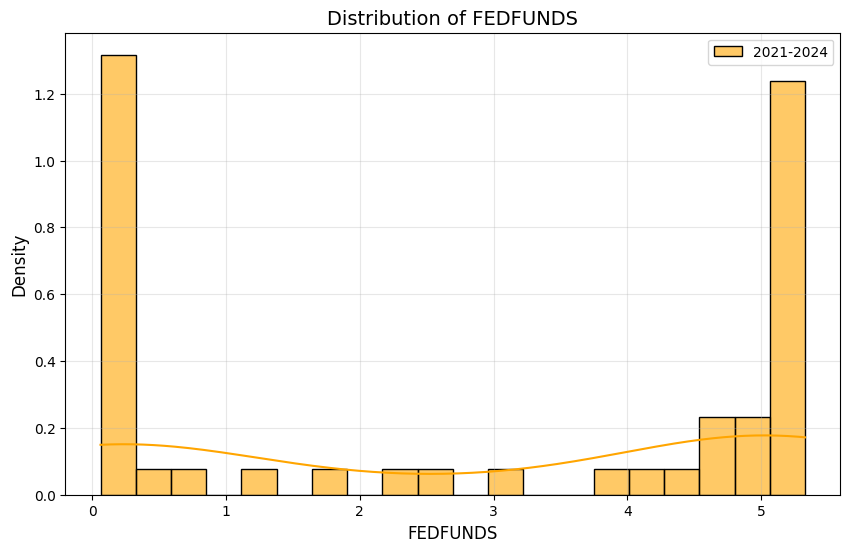

In [ ]:
plt.figure(figsize=(14, 6))
for column in ['FEDFUNDS']:
    plt.plot(dffs['DATE'], dffs[column], label=column)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trends Over Time')
plt.legend()
plt.show()

variables = ['FEDFUNDS']

# Plot distributions
for var in variables:
    plt.figure(figsize=(10, 6))

    # Histogram and KDE
    sns.histplot(dffs[var], kde=True, color='orange', label='2021-2024', stat="density", bins=20, alpha=0.6)

    # Formatting
    plt.title(f'Distribution of {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

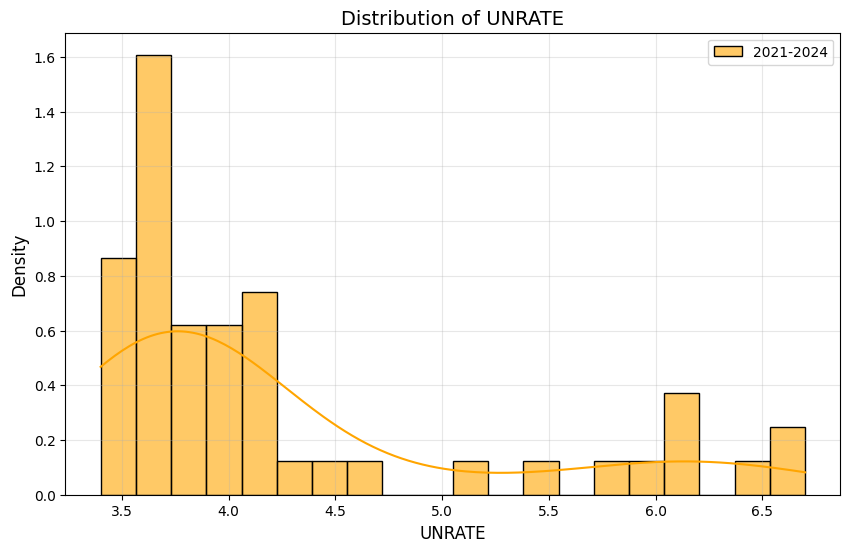

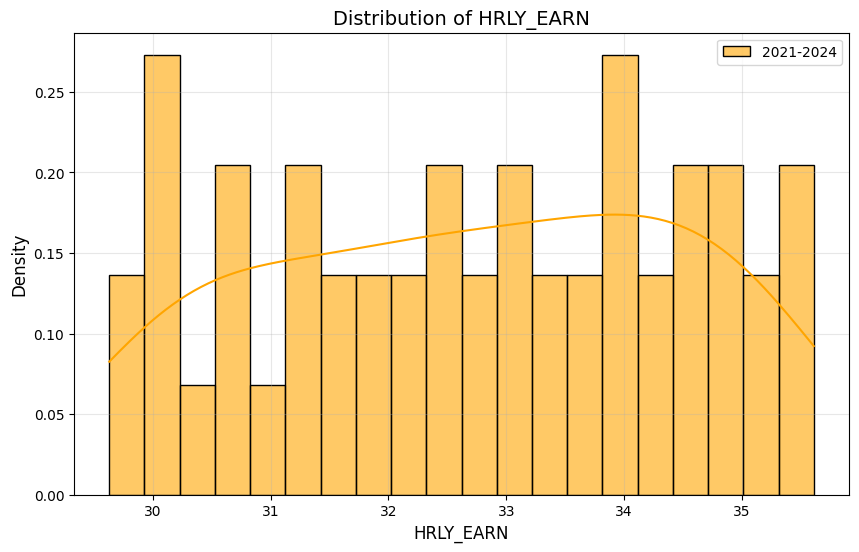

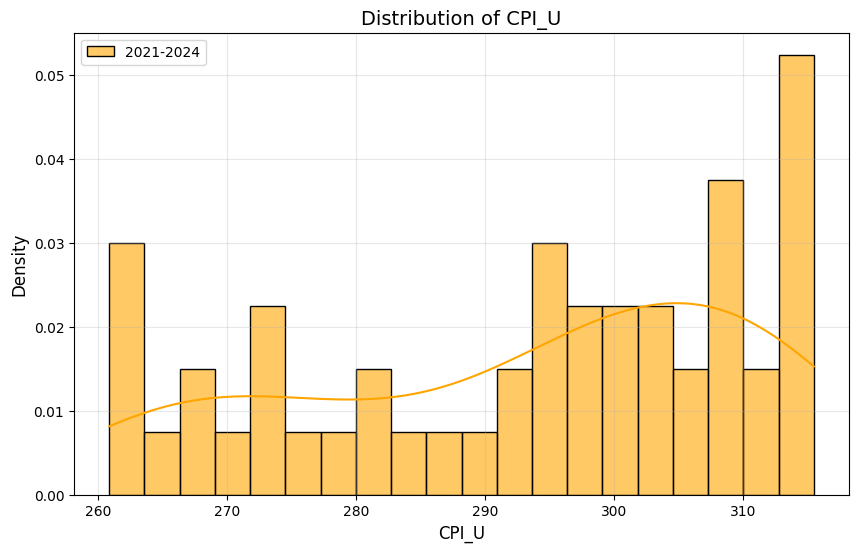

In [ ]:
variables = ['UNRATE', 'HRLY_EARN', 'CPI_U']

# Plot distributions
for var in variables:
    plt.figure(figsize=(10, 6))

    # Histogram and KDE
    sns.histplot(dffs[var], kde=True, color='orange', label='2021-2024', stat="density", bins=20, alpha=0.6)

    # Formatting
    plt.title(f'Distribution of {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

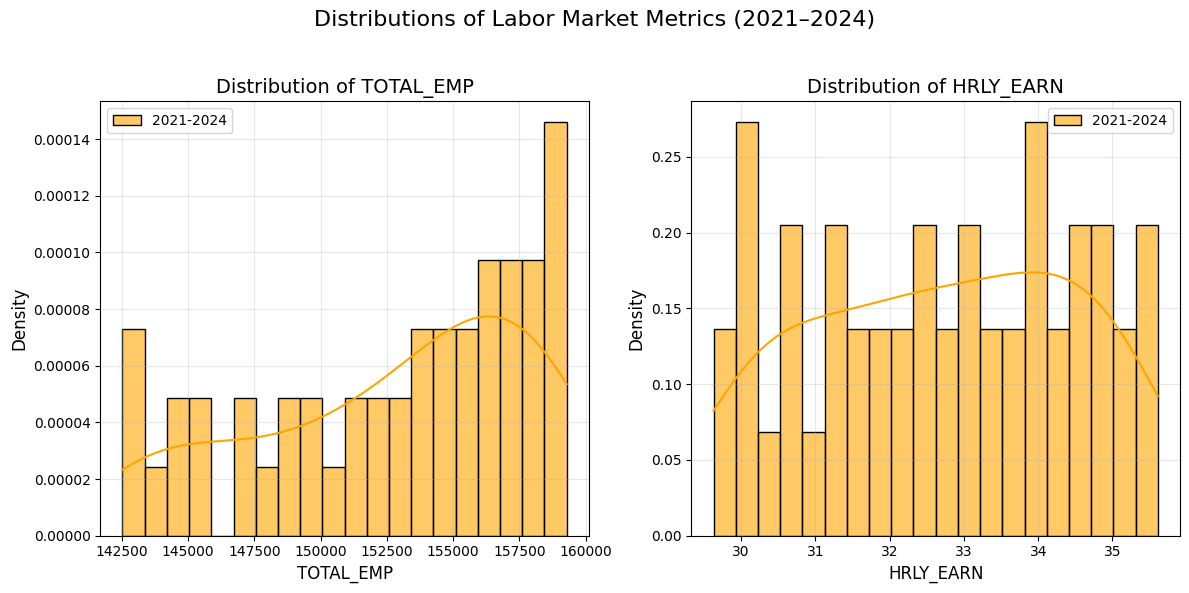

In [ ]:
variables = ['TOTAL_EMP', 'HRLY_EARN'] # 'LNS14000001', 'LNS14000002'

# Adjusted code for 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Distributions of Labor Market Metrics (2021–2024)', fontsize=16)

# Variables and axes setup
for i, var in enumerate(variables):
    ax = axs[i % 2]  # Determine the position in the grid
    sns.histplot(dffs[var], kde=True, ax=ax, color='orange', label='2021-2024', stat="density", bins=20, alpha=0.6)

    # Formatting
    ax.set_title(f'Distribution of {var}', fontsize=14)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

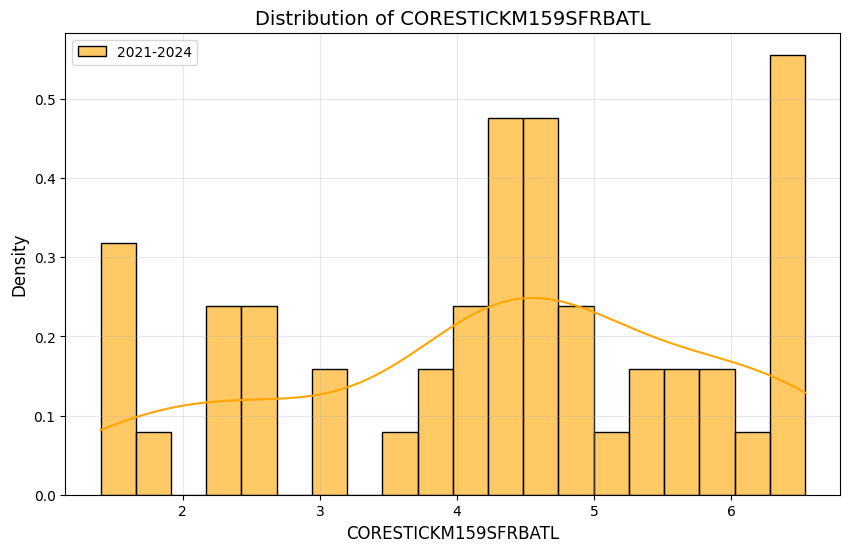

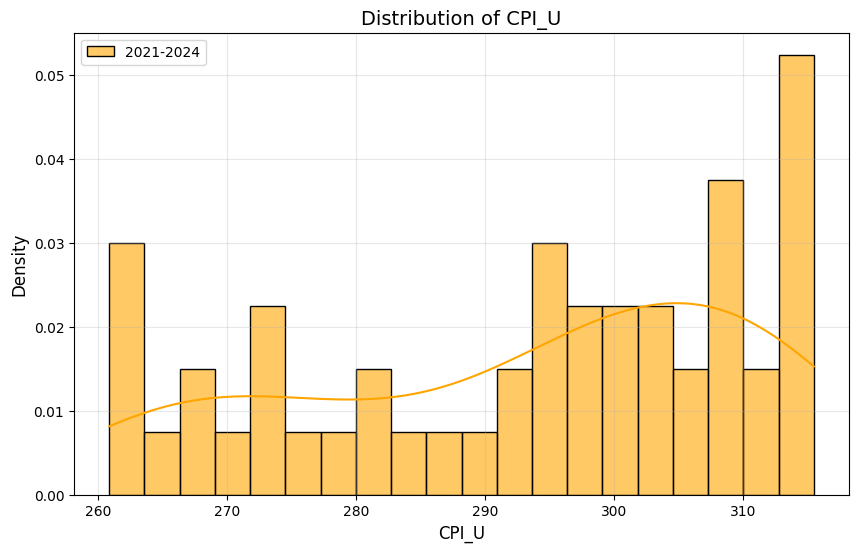

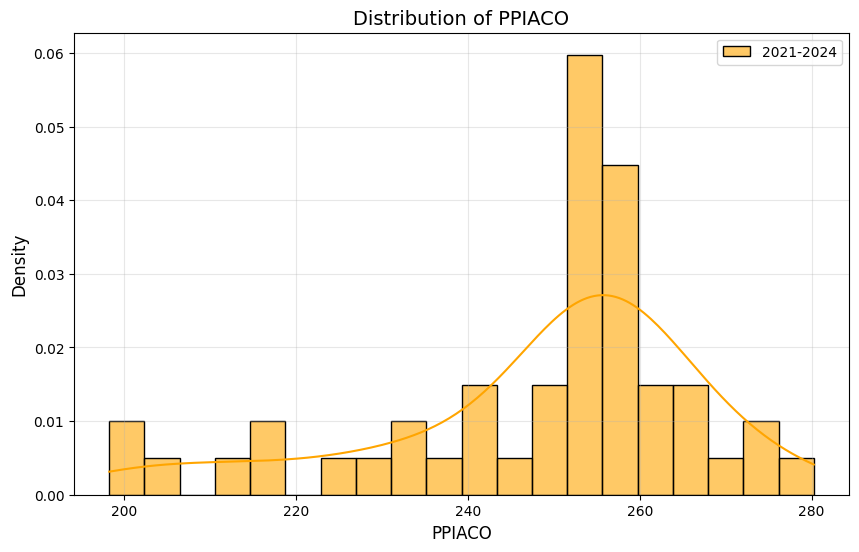

In [ ]:
variables = ['CORESTICKM159SFRBATL', 'CPI_U', 'PPIACO']

# Plot distributions
for var in variables:
    plt.figure(figsize=(10, 6))

    # Histogram and KDE
    sns.histplot(dffs[var], kde=True, color='orange', label='2021-2024', stat="density", bins=20, alpha=0.6)

    # Formatting
    plt.title(f'Distribution of {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

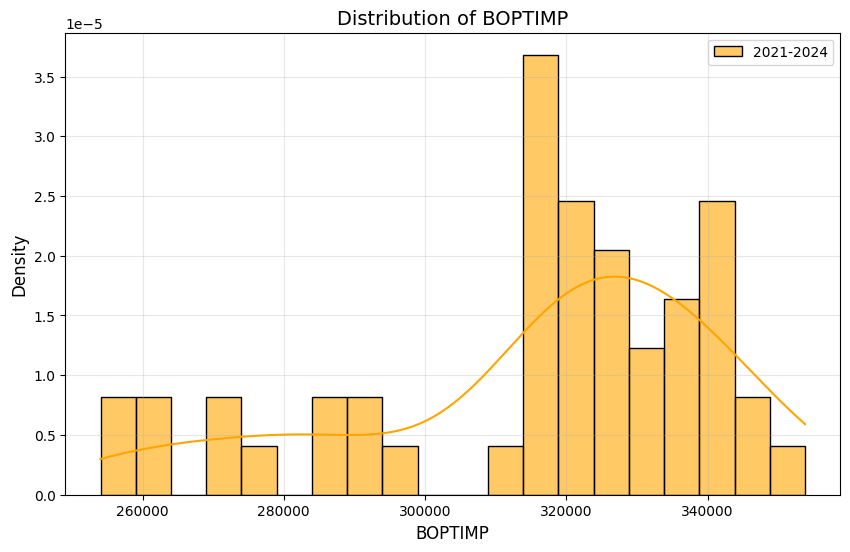

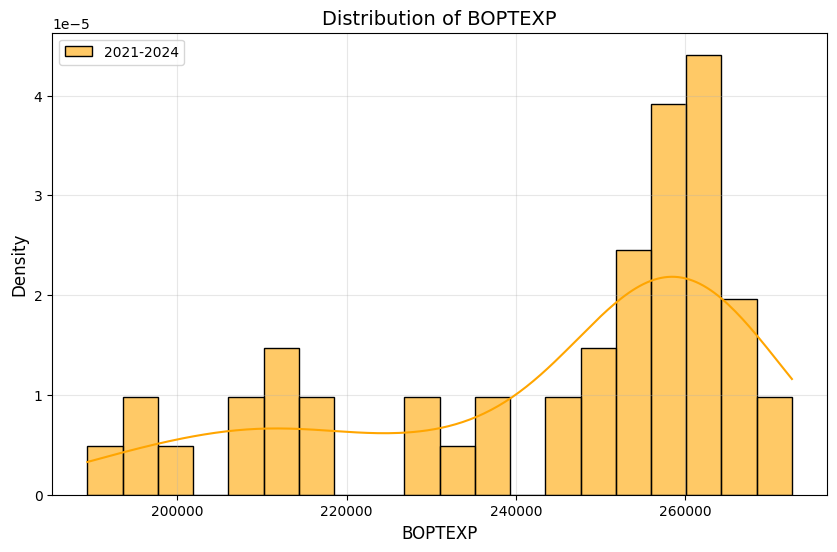

In [ ]:
variables = ['BOPTIMP', 'BOPTEXP']

# Plot distributions
for var in variables:
    plt.figure(figsize=(10, 6))

    # Histogram and KDE
    sns.histplot(dffs[var], kde=True, color='orange', label='2021-2024', stat="density", bins=20, alpha=0.6)

    # Formatting
    plt.title(f'Distribution of {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# **Modeling**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

#### Linear Regression with Time Series

In [ ]:
def cross_validate_linear_regression(df, n_splits, random_state):
    # Shift the target for 2-month prediction
    df['UNRATE_next_2_months'] = df['UNRATE'].shift(-2)
    train_data = df.copy().dropna(subset=['UNRATE_next_2_months'])

    X = train_data.drop(columns=['DATE', 'UNRATE', 'UNRATE_next_2_months'])
    y = train_data['UNRATE_next_2_months']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    regression_model = LinearRegression()

    # Perform cross-validation
    cv_mse_scores = cross_val_score(regression_model, X_scaled, y, scoring='neg_mean_squared_error', cv=kf)
    mse_scores = -cv_mse_scores
    mean_mse = np.mean(mse_scores)
    print("MSE per fold:", mse_scores)
    print("Mean MSE (Cross-validation):", mean_mse)

    # Fit model and make predictions
    regression_model.fit(X_scaled, y)
    y_pred = regression_model.predict(X_scaled)
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error for all the training data:", mse)

    # Make prediction for 2024-12
    last_known_row = train_data.iloc[-2]  # Use the 2024-10 row (predicting for 2024-12)
    predict_features = last_known_row.drop(['DATE', 'UNRATE', 'UNRATE_next_2_months']).values.reshape(1, -1)
    predict_features_scaled = scaler.transform(predict_features)
    unrate_pred = regression_model.predict(predict_features_scaled)[0]
    print(f"Predicted Unemployment Rate for 2024-12: {unrate_pred}")

    return X, X_scaled, y, y_pred, regression_model

In [ ]:
# This is the predicted UNRATE for 2024-12 using data from 2014-01-01 to 2024-11-01
X, X_scaled, y, y_pred, regression_model = cross_validate_linear_regression(dff, n_splits=5, random_state=42)

MSE per fold: [0.50389593 0.54940345 4.18060164 0.62527294 2.53116209]
Mean MSE (Cross-validation): 1.6780672084162898
Mean Squared Error for all the training data: 1.3634916294505035
Predicted Unemployment Rate for 2024-12: 3.7637276533669395


In [ ]:
# This is the result for selected timeline
X, X_scaled, y, y_pred, regression_model = cross_validate_linear_regression(dffs, n_splits=5, random_state=42)

MSE per fold: [0.03396085 0.02373031 0.0724062  0.08630479 0.03960064]
Mean MSE (Cross-validation): 0.05120055980729219
Mean Squared Error for all the training data: 0.025978099557927053
Predicted Unemployment Rate for 2024-12: 4.136062506136972


In [ ]:
def regression_summary(X, X_scaled, y, y_pred, regression_model):
    # Predictions and residuals
    y_pred = regression_model.predict(X_scaled)
    residuals = y - y_pred
    n, p = X_scaled.shape  # Number of observations and predictors

    # Variance of residuals
    residual_var = np.sum(residuals ** 2) / (n - p - 1)

    # Standard errors of coefficients
    X_design = np.hstack([np.ones((n, 1)), X_scaled])  # Add intercept column
    XtX_inv = np.linalg.inv(X_design.T @ X_design)
    coef_se = np.sqrt(np.diag(XtX_inv) * residual_var)

    # Confidence intervals
    t_value = t.ppf(1 - 0.025, df=n - p - 1)  # 95% confidence level
    coefficients = np.concatenate([[regression_model.intercept_], regression_model.coef_])
    lower_ci = coefficients - t_value * coef_se
    upper_ci = coefficients + t_value * coef_se

    # Combine results into a DataFrame
    summary_df = pd.DataFrame({
        "Variable": ["Intercept"] + list(X.columns),
        "Estimate": coefficients,
        "Standard Error": coef_se,
        "Lower 95% CI": lower_ci,
        "Upper 95% CI": upper_ci
    })

    return summary_df

summary_df = regression_summary(X, X_scaled, y, y_pred, regression_model)
summary_df

,Variable,Estimate,Standard Error,Lower 95% CI,Upper 95% CI
0,Intercept,4.161702,0.026146,4.108772,4.214633
1,CORESTICKM159SFRBATL,-0.236012,0.124385,-0.487817,0.015793
2,PPIACO,-0.451401,0.182136,-0.820116,-0.082687
3,BOPTIMP,0.196942,0.183380,-0.174292,0.568177
4,BOPTEXP,0.160232,0.208298,-0.261446,0.581909
5,FEDFUNDS,0.292168,0.293522,-0.302036,0.886372
6,TOTAL_EMP,-3.558899,0.444494,-4.458731,-2.659067
7,HRLY_EARN,0.507100,0.630771,-0.769830,1.784029
8,CPI_U,2.387810,0.804767,0.758644,4.016976


# Time Series

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
# Ensure DATE is the index
dffss = dffs.copy()
dffs.set_index('DATE', inplace=True)

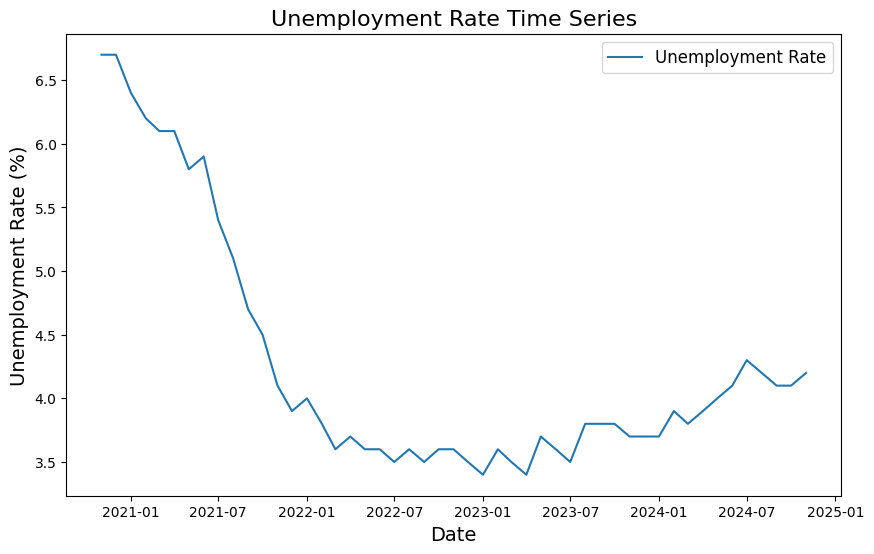

In [ ]:
# Select the relevant series
unrate_series = dffs['UNRATE'].dropna()
# unrate_men = dffs['LNS14000001'].dropna()  # Unemployment Rate - Men
# unrate_women = dffs['LNS14000002'].dropna()  # Unemployment Rate - Women

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(unrate_series, label='Unemployment Rate')
# plt.plot(unrate_men, label='Unemployment Rate - Men', color='blue')
# plt.plot(unrate_women, label='Unemployment Rate - Women', color='red')

# Add title and labels
plt.title('Unemployment Rate Time Series', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Unemployment Rate (%)', fontsize=14)

# Add legend
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.grid(False)
plt.show()

Our data is not stationary enough, but still try ARIMA model.

Pros and Cons: Report P.5-P.8

In [ ]:
adf_test = adfuller(dffs['UNRATE'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1]) # Indicates non-stationarity, because p-value>0.05, need to difference

ADF Statistic: -2.661562
p-value: 0.080929


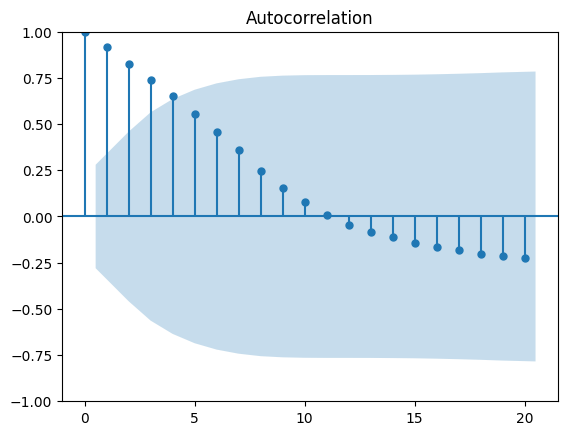

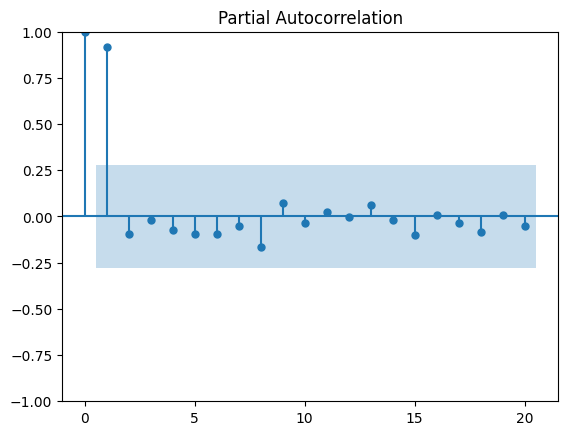

In [ ]:
plot_acf(dffs['UNRATE'], lags=20)
plot_pacf(dffs['UNRATE'], lags=20)
plt.show()

In [ ]:
def evaluate_and_forecast_arima_model(data, column, order=(1, 0, 1), train_ratio=0.8, forecast_steps=50, predict_steps=1):
    """
    Evaluate ARIMA model and predict future values.

    Parameters:
    - data: DataFrame containing the time series data
    - column: str, name of the column to use as the target variable
    - order: tuple, (p, d, q) parameters for the ARIMA model
    - train_ratio: float, ratio of data to use for training
    - forecast_steps: int, number of steps to forecast on test set
    - predict_steps: int, number of steps to predict beyond the dataset

    Returns:
    - model_fit: Fitted ARIMA model
    - test_forecast_series: Forecasted values for the test set
    - future_forecast: Forecasted values for future periods
    - train_mse: Mean squared error for the training set
    - test_mse: Mean squared error for the test set
    - total_mse: Mean squared error for the entire dataset
    - total_rmse: Root mean squared error for the entire dataset
    """
    # Split the data into train and test sets
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]

    # Fit the ARIMA model on the training dataset
    model_train = ARIMA(train[column], order=order)
    model_train_fit = model_train.fit()

    # Forecast on the test dataset
    test_forecast = model_train_fit.get_forecast(steps=len(test))
    test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

    # Combine fitted values (train) and forecasted values (test)
    combined_predictions = pd.concat([model_train_fit.fittedvalues, test_forecast_series])

    # Align predictions with the original dataset
    actual_values = data[column]
    combined_predictions = combined_predictions.reindex(actual_values.index)

    # Calculate errors
    train_mse = mean_squared_error(train[column], model_train_fit.fittedvalues)
    test_mse = mean_squared_error(test[column], test_forecast_series)
    total_mse = mean_squared_error(actual_values, combined_predictions)
    train_rmse = train_mse**0.5
    test_rmse = test_mse**0.5
    total_rmse = total_mse**0.5

    # Fit ARIMA model on the entire dataset
    model_full = ARIMA(data[column], order=order)
    model_full_fit = model_full.fit()

    # Forecast future values
    future_forecast = model_full_fit.get_forecast(steps=predict_steps)
    future_forecast_mean = future_forecast.predicted_mean
    future_forecast_ci = future_forecast.conf_int()

    # Print forecast for future periods
    print(f"Forecast for the next {predict_steps} periods:")
    print(future_forecast_mean)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train[column], label='Training Data')
    plt.plot(test[column], label='Actual Data', color='orange')
    plt.plot(test_forecast_series, label='Forecasted Data', color='green')
    plt.fill_between(test.index,
                     test_forecast.conf_int().iloc[:, 0],
                     test_forecast.conf_int().iloc[:, 1],
                     color='k', alpha=.15)
    plt.title('ARIMA Model Evaluation')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()

    # Print MSE and RMSE
    print(f"Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}")
    print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Total MSE: {total_mse:.4f}, Total RMSE: {total_rmse:.4f}")

    return model_full_fit, future_forecast_mean, future_forecast_ci, train_mse, test_mse, total_mse, total_rmse

Forecast for the next 1 periods:
2024-12-01    4.225451
Freq: MS, dtype: float64


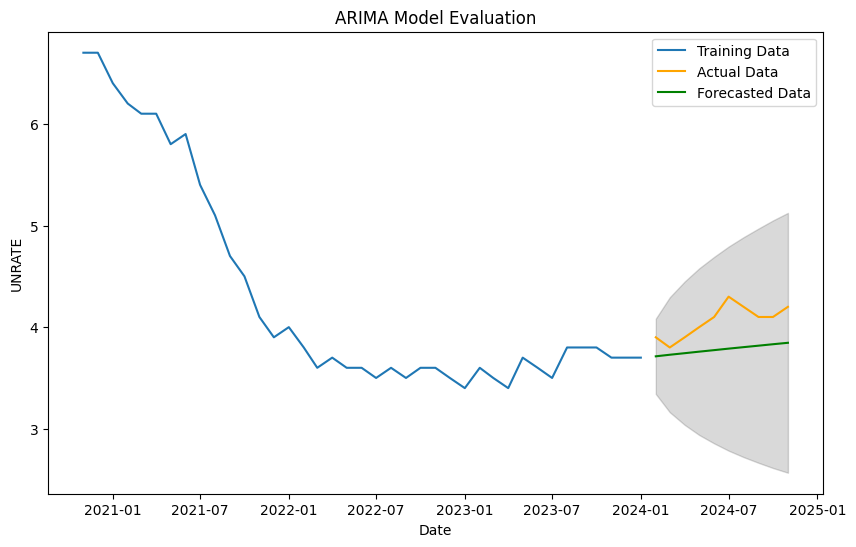

Train MSE: 0.1060, Train RMSE: 0.3255
Test MSE: 0.0925, Test RMSE: 0.3041
Total MSE: 0.1032, Total RMSE: 0.3213
Forecasted UNRATE for 2024-12: 4.225450912869349
95% Confidence Interval for 2024-12: lower UNRATE    3.877949
upper UNRATE    4.572953
Name: 2024-12-01 00:00:00, dtype: float64


In [ ]:
model_fit, future_forecast, future_ci, train_mse, test_mse, total_mse, total_rmse = evaluate_and_forecast_arima_model(
    data=dffs,
    column='UNRATE',
    order=(1, 0, 1),  # ARIMA(p, d, q)
    train_ratio=0.8,
    forecast_steps=len(dffs) - int(len(dffs) * 0.8),  # Forecast on test data
    predict_steps=1  # Predict one step ahead (e.g., 2024-12)
)

# Get the forecasted value and confidence interval for 2024-12
print("Forecasted UNRATE for 2024-12:", future_forecast.iloc[-1])
print("95% Confidence Interval for 2024-12:", future_ci.iloc[-1])

Forecast for the next 1 periods:
2024-12-01    4.236854
Freq: MS, dtype: float64


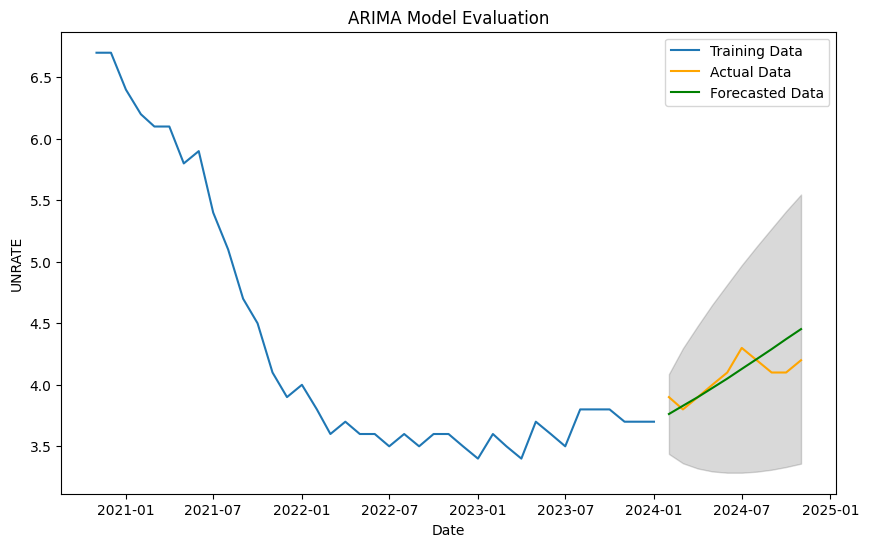

Train MSE: 0.1188, Train RMSE: 0.3447
Test MSE: 0.0226, Test RMSE: 0.1504
Total MSE: 0.0992, Total RMSE: 0.3149
Forecasted UNRATE for 2024-12: 4.236854204539819
95% Confidence Interval for 2024-12: lower UNRATE    3.887692
upper UNRATE    4.586017
Name: 2024-12-01 00:00:00, dtype: float64


In [ ]:
model_fit, future_forecast, future_ci, train_mse, test_mse, total_mse, total_rmse = evaluate_and_forecast_arima_model(
    data=dffs,
    column='UNRATE',
    order=(2, 0, 1),  # ARIMA(p, d, q)
    train_ratio=0.8,
    forecast_steps=len(dffs) - int(len(dffs) * 0.8),  # Forecast on test data
    predict_steps=1  # Predict one step ahead (e.g., 2024-12)
)

# Get the forecasted value and confidence interval for 2024-12
print("Forecasted UNRATE for 2024-12:", future_forecast.iloc[-1])
print("95% Confidence Interval for 2024-12:", future_ci.iloc[-1])